In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
MODEL_DIR = 'saved_models'
os.makedirs(MODEL_DIR, exist_ok=True)

In [4]:
data = pd.read_csv('data/cleaned_tweets.csv', encoding = 'latin')
print(data.shape)
data = data[~data['text_cleaned'].isna()]
print(data.shape)
df = data[['sentiment', 'text_cleaned']]

(1600000, 7)
(1596818, 7)


In [5]:
label_encoder = LabelEncoder()
df['sentiment'] = label_encoder.fit_transform(df['sentiment'])

C:\Users\Skyglow\AppData\Local\Temp\ipykernel_33252\3449995347.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment'] = label_encoder.fit_transform(df['sentiment'])


In [6]:
TRAIN_SIZE = 0.8
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 30 
EMBEDDING_DIM = 100  

In [7]:
train_data, test_data = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=77)

In [8]:
print("Train Data size:", len(train_data))
print("Test Data size:", len(test_data))

Train Data size: 1277454
Test Data size: 319364


In [9]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(train_data['text_cleaned'])

In [10]:
X_train = tokenizer.texts_to_sequences(train_data['text_cleaned'])
X_test = tokenizer.texts_to_sequences(test_data['text_cleaned'])

In [11]:
X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

In [12]:
y_train = train_data['sentiment'].values
y_test = test_data['sentiment'].values

In [13]:
model = Sequential()
model.add(Embedding(input_dim=MAX_NB_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [14]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 100)           10000000  
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 10,044,353
Trainable params: 10,044,353
No

In [15]:
BATCH_SIZE = 64
EPOCHS = 10

In [16]:
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                    validation_split=0.2, verbose=1)

Epoch 1/10
15969/15969 [==============================] - 1690s 106ms/step - loss: 0.4369 - accuracy: 0.8033 - val_loss: 0.3967 - val_accuracy: 0.8192
Epoch 2/10
15969/15969 [==============================] - 1676s 105ms/step - loss: 0.3821 - accuracy: 0.8340 - val_loss: 0.3864 - val_accuracy: 0.8255
Epoch 3/10
15969/15969 [==============================] - 1688s 106ms/step - loss: 0.3493 - accuracy: 0.8516 - val_loss: 0.3979 - val_accuracy: 0.8236
Epoch 4/10
15969/15969 [==============================] - 1682s 105ms/step - loss: 0.3193 - accuracy: 0.8668 - val_loss: 0.4077 - val_accuracy: 0.8228
Epoch 5/10
15969/15969 [==============================] - 1692s 106ms/step - loss: 0.2911 - accuracy: 0.8800 - val_loss: 0.4226 - val_accuracy: 0.8173
Epoch 6/10
15969/15969 [==============================] - 1693s 106ms/step - loss: 0.2653 - accuracy: 0.8915 - val_loss: 0.4539 - val_accuracy: 0.8127
Epoch 7/10
15969/15969 [==============================] - 1694s 106ms/step - loss: 0.2430 - ac

In [32]:
with open('saved_models/lstm_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

In [17]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {accuracy:.4f}")


Test Accuracy: 0.7993


In [18]:
model_path = os.path.join(MODEL_DIR, 'lstm_model.h5')
model.save(model_path)
print(f"LSTM model saved at: {model_path}")


LSTM model saved at: saved_models\lstm_model.h5


In [19]:
tokenizer_path = os.path.join(MODEL_DIR, 'tokenizer.joblib')
import joblib
joblib.dump(tokenizer, tokenizer_path)
print(f"Tokenizer saved at: {tokenizer_path}")

Tokenizer saved at: saved_models\tokenizer.joblib


In [21]:
def plot_training_history(history):

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

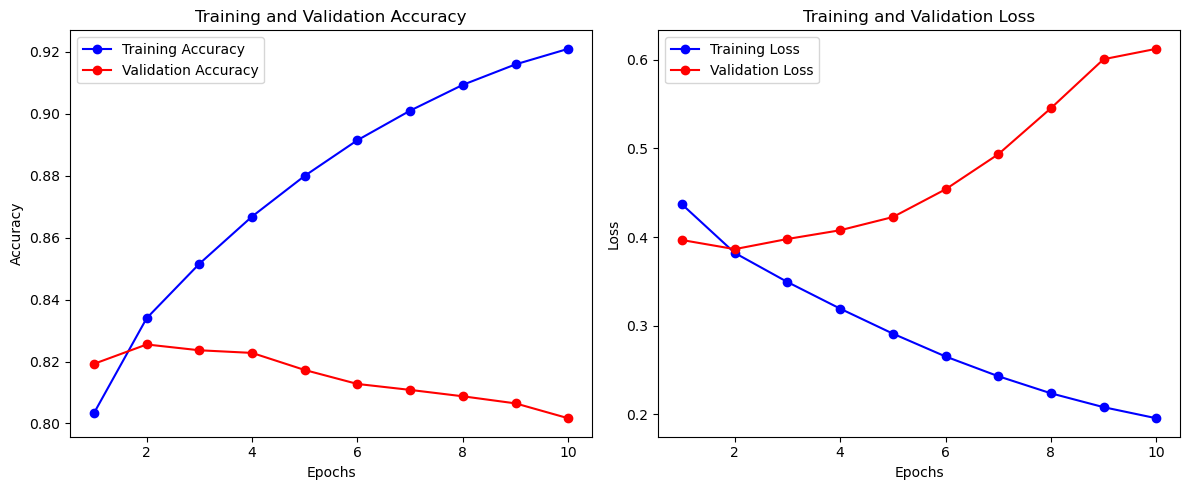

In [22]:
plot_training_history(history)

In [24]:
y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()

9981/9981 [==============================] - 55s 5ms/step


In [27]:
cm = confusion_matrix(y_test, y_pred)

def plot_confusion_matrix(cm):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

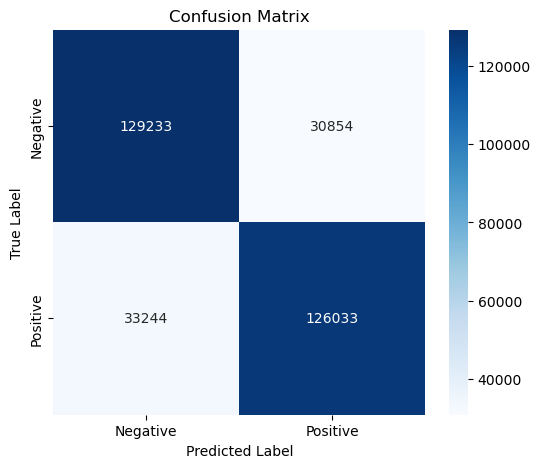

In [28]:
plot_confusion_matrix(cm)

In [29]:
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

              precision    recall  f1-score   support

    Negative       0.80      0.81      0.80    160087
    Positive       0.80      0.79      0.80    159277

    accuracy                           0.80    319364
   macro avg       0.80      0.80      0.80    319364
weighted avg       0.80      0.80      0.80    319364

